# Introduzione al Machine Learning 2023-2024
### Bernardini Jacopo, Ciocca Giorgio, Marini Tommaso
### Exam Project, Second Part: Data Exploration, Network  and Classification

## 1. Data Exploration

Libraries import and setting of the device, seeds.

In [187]:
import copy
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import seaborn as sns
import shutil
import statistics
import time
import torch 
import warnings
import zipfile

from collections import Counter
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

random.seed(69420)
torch.manual_seed(69420)

Using device: cuda


Dataset extraction from https://www.kaggle.com/datasets/gustavoachavez/architectural-styles-periods-dataset.

We create a new directory into which we extract our data.

In [188]:
# Define the path to the zip file and the extraction directory
zip_path = '../archive.zip'
root_dir = '../data/'

if os.path.exists(root_dir):
    for filename in os.listdir(root_dir):
        file_path = os.path.join(root_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

if not os.path.exists(root_dir):
    os.makedirs(root_dir)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(root_dir)

### Data check

First, we walk through the directory tree and check the extensions of the image files. We want to verify if all the images are ``.jpeg`` files

In [189]:
non_jpg_found = False

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            if not filename.lower().endswith('.jpg'):
                print(f"Image file is not in the '.jpg' format: {os.path.join(dirpath, filename)}")
                non_jpg_found = True

if not non_jpg_found:
    print("All images are in the '.jpg' format.")

All images are in the '.jpg' format.


In [190]:
# # Initialize the list to store the sample images
# sample_images = []
# 
# # Get a list of all the main folders
# capstoneFolders = sorted([os.path.join(root_dir, name) for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))])
# 
# # For each main folder, get the first image from the first periodFolder
# for capstoneFolder in capstoneFolders:
#     # Get a list of all the periodFolders in the main folder
#     periodFolders = sorted([os.path.join(capstoneFolder, name) for name in os.listdir(capstoneFolder) if os.path.isdir(os.path.join(capstoneFolder, name))])
# 
#     for periodFolder in periodFolders:
#         # Get a list of all the images in the periodFolder
#         images = sorted([os.path.join(periodFolder, name) for name in os.listdir(periodFolder) if os.path.isfile(os.path.join(periodFolder, name))])
# 
#         if images:  # Check if the list is not empty
#             sample_images.append(images[0])
#             break  # Stop after the first periodFolder
# 
# # Create a 3x4 matrix of images
# fig, axs = plt.subplots(3, 4, figsize=(15, 10))
# 
# for i in range(3):
#     for j in range(4):
#         # Select an image in order
#         image_index = i*4 + j
#         if image_index < len(sample_images):
#             image_path = sample_images[image_index]
# 
#             # Read and display the image
#             img = mpimg.imread(image_path)
#             axs[i, j].imshow(img)
#             axs[i, j].axis('off')  # Hide the axis
# 
# plt.tight_layout()
# plt.show()
# 
# print("sample_images list:", sample_images)

Then, we count how many images are there in the data set for each width and height.

In [191]:
widths = []
heights = []

processed_images = 0

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                
                processed_images += 1
        except IOError:
            print(f"Cannot open image file '{img_path}', skipping.")

print(f"Processed images: {processed_images}")

Processed images: 12291


We plot the width and height distributions. 

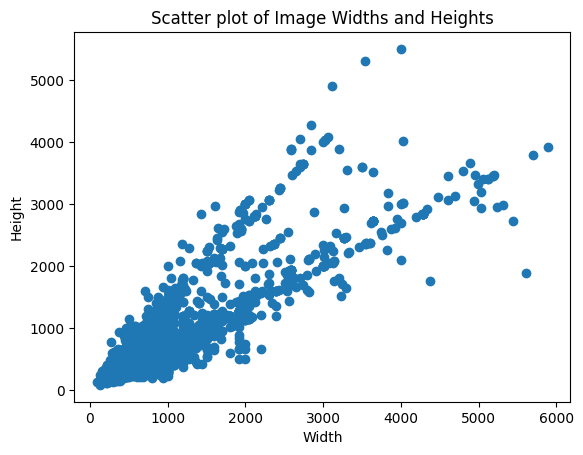

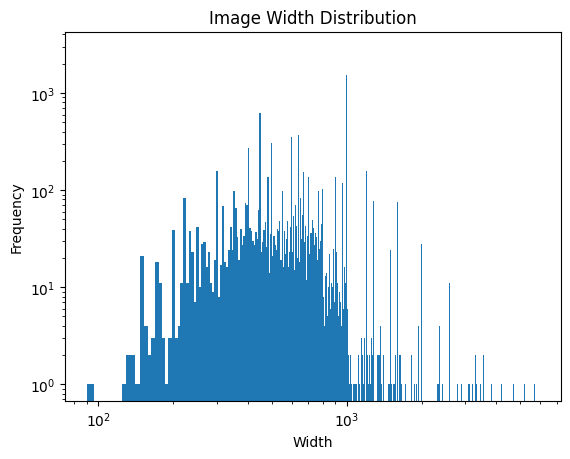

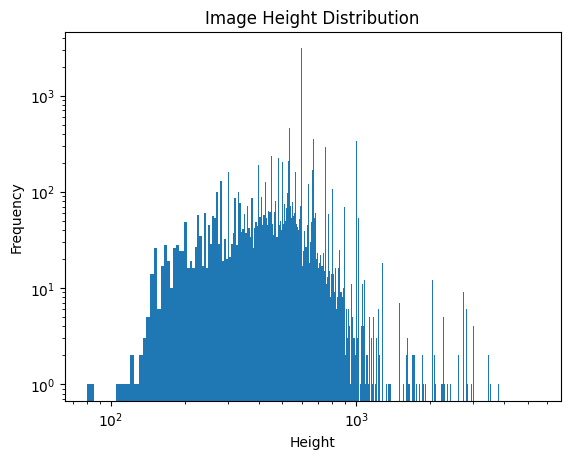

In [192]:
# Scatter plot of widths and heights
plt.scatter(widths, heights)
plt.title('Scatter plot of Image Widths and Heights')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# Plot a histogram of the widths
plt.hist(widths, bins=len(set(widths)))
plt.title('Image Width Distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

# Plot a histogram of the heights
plt.hist(heights, bins=len(set(heights)))
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.show()

We see that both the width and the height distributions have two peaks.

We check if the classes are evenly distributed.

Folder corresponding to each label:
Label 0: 21st_Century
Label 1: Baroque
Label 2: Classical
Label 3: Early_Christian_Medieval
Label 4: Eclecticism
Label 5: Modernism
Label 6: Neoclassicism
Label 7: Renaissance_and_Colonialism
Label 8: Revivalism


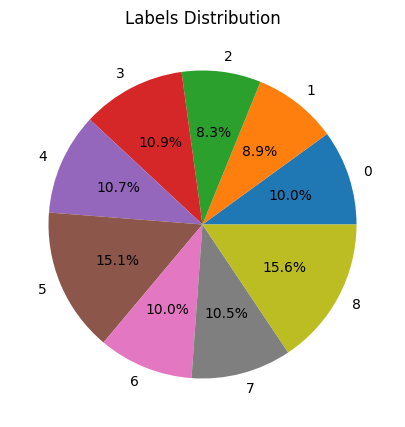

In [193]:
# Load the dataset
data = datasets.ImageFolder(root=root_dir + 'Capstone_Architectural_Styles_dataset/')

# Extract the labels from the dataset
labels = [label for _, label in data]

# Count the frequency of each label
label_counter = Counter(labels)

# Print the folder corresponding to each label
print("Folder corresponding to each label:")
for folder, label in data.class_to_idx.items():
    print(f"Label {label}: {folder}")

# Plot the pie chart
plt.figure(figsize=(10, 5))
plt.pie(label_counter.values(), labels=label_counter.keys(), autopct='%1.1f%%')
plt.title('Labels Distribution')
plt.show()

Finally, we study the color format of the images.

Number of RGB images: 12092
Number of RGBA images: 47
Number of L images: 131
Number of P images: 15
Number of CMYK images: 5
Number of LA images: 1


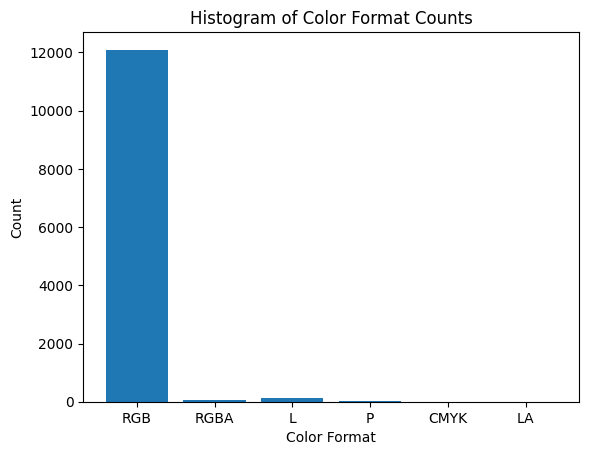

In [194]:
color_formats = set()
color_formats_list = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)

        try:
            with Image.open(img_path) as img:
                color_formats_list.append(img.mode)
        except IOError:
            print(f"Cannot open image file '{img_path}', skipping.")
            

color_format_counts = Counter(color_formats_list)

for format, count in color_format_counts.items():
    print(f"Number of {format} images: {count}")


plt.bar(color_format_counts.keys(), color_format_counts.values())
plt.xlabel('Color Format')
plt.ylabel('Count')
plt.title('Histogram of Color Format Counts')
plt.show()

We see that most of the images are in RGB format. We drop the others for uniformity.

In [195]:
removeBool = False
removedCounter = 0

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)

        # Open the image and check its mode
        try:
            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    removeBool = True
            if removeBool:
                os.remove(img_path)
                removedCounter += 1
                removeBool = False
        except IOError as e:
            print(f"Cannot open image file '{img_path}'. Error: {e}\n")
            
print(f"Number of removed images: {removedCounter}")

Number of removed images: 199


### Data Preparation

To prepare the images for the neural network, we need to resize them to a common format. Since the proportion of an image is an important feature, we decide to pad all the images to squares before resizing them. 

In [196]:
def pad_image_to_square(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            new_size = max(width, height)
            
            new_img = Image.new("RGB", (new_size, new_size))
            new_img.paste(img, ((new_size - width) // 2, (new_size - height) // 2))
            
        new_img.save(image_path)
    except IOError:
        print(f"Cannot open image file '{image_path}', skipping.")

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)
        pad_image_to_square(img_path)

We check the dimension of the images after the padding, and plot the size distribution and mode.

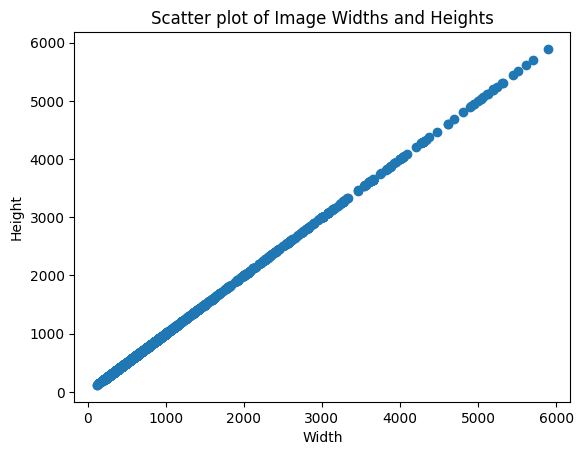

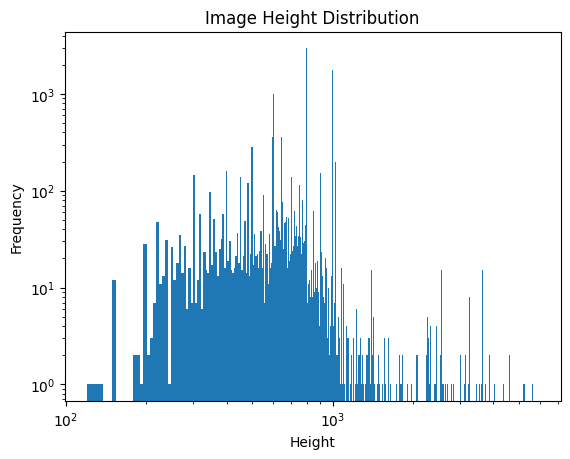

Mode of new size: 800


In [197]:
widths = []
heights = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)

        try:
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                    
        except IOError:
            print(f"Cannot open image file '{img_path}', skipping.")


# Scatter plot of widths and heights
plt.scatter(widths, heights)
plt.title('Scatter plot of Image Widths and Heights')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# Plot a histogram of the heights
plt.hist(heights, bins=len(set(heights)))
plt.title('Image Height Distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

print(f'Mode of new size: {statistics.mode(heights)}')

We resize every image to the mode, so that we do not modify the most number of images. To resize the images we use the LANCZOS filter.

In [215]:
def resize_image(image_path, target_size):
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size, Image.LANCZOS)
        return img
    except UnidentifiedImageError:
        print(f"Cannot identify image file '{image_path}', skipping.")
        return None

target_size = (227, 227)

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)

        img = resize_image(img_path, target_size)

        if img is not None:
            img.save(img_path)

Finally, we transform the images to tensors, which can be fed to the neural network. We also extract the label classes and label them with an index.

In [216]:
transform = transforms.Compose([
    transforms.ToTensor()
])

data = datasets.ImageFolder(root=root_dir+r'Capstone_Architectural_Styles_dataset/', transform=transform)
num_images = len(data)

num_classes = len(data.classes)

class_names = data.classes

# Class to index mapping
class_to_idx = data.class_to_idx

print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Class to index mapping: {class_to_idx}")

Number of images: 12092
Number of classes: 9
Class names: ['21st_Century', 'Baroque', 'Classical', 'Early_Christian_Medieval', 'Eclecticism', 'Modernism', 'Neoclassicism', 'Renaissance_and_Colonialism', 'Revivalism']
Class to index mapping: {'21st_Century': 0, 'Baroque': 1, 'Classical': 2, 'Early_Christian_Medieval': 3, 'Eclecticism': 4, 'Modernism': 5, 'Neoclassicism': 6, 'Renaissance_and_Colonialism': 7, 'Revivalism': 8}


## 2. Network

We start the preparation of our network.

First, we split the data in train set and test set with a ratio of 80 to 20.

In [219]:
train_data, test_data = random_split(data, [0.8, 0.2])

We check if the classes are evenly distributed among the two subsets after the splitting.

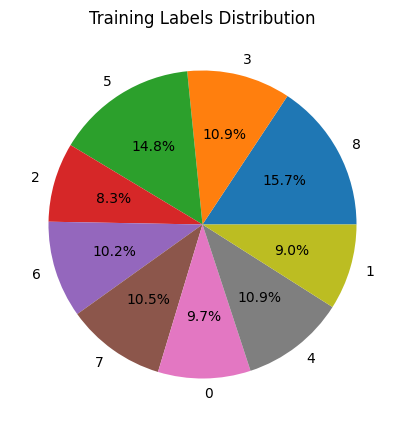

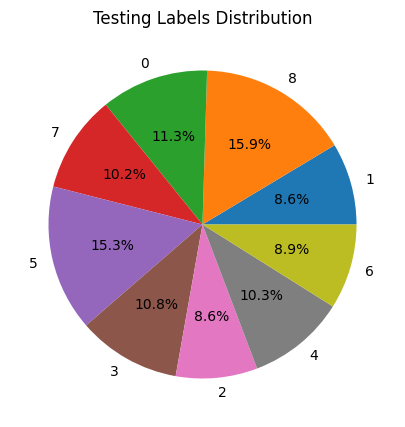

In [220]:
train_labels = [label for _, label in train_data]
test_labels = [label for _, label in test_data]

label_counter_train = Counter(train_labels)
label_counter_test = Counter(test_labels)

plt.figure(figsize=(10, 5))
plt.pie(label_counter_train.values(), labels=label_counter_train.keys(), autopct='%1.1f%%')
plt.title('Training Labels Distribution')
plt.show()

plt.figure(figsize=(10, 5))
plt.pie(label_counter_test.values(), labels=label_counter_test.keys(), autopct='%1.1f%%')
plt.title('Testing Labels Distribution')
plt.show()

We now set up the dataloader to train and test the neural network in batches.

In [221]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    )

test_dataloader = DataLoader(dataset = test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    )

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001996FC13170>, <torch.utils.data.dataloader.DataLoader object at 0x000001981749D490>)
Length of train dataloader: 303 batches of 32
Length of test dataloader: 76 batches of 32


### Convolutional Neural Network

We define a Convolutional Neural Network, based on the AlexNet architecture. We adapt it to our dataset, for example by changing the filter dimension to adapt it to the dimension of our images. 

In [222]:
class silvio_christian_pomelli(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=96, 
                      kernel_size=11,#valore giusto 12
                      stride=4,#valore giusto 4
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,#valore giusto 4
                         stride=2),
            nn.BatchNorm2d(96),
            nn.Conv2d(in_channels=96,
                      out_channels=256,
                      kernel_size=5,#valore giusto 8
                      stride=1,#valore giusto 2
                      padding=2),#valore giusto 0
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,#valore giusto 4
                         stride=2),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256,
                      out_channels=384,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384,
                      out_channels=384,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,#valore giusto boh forse 3
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*5*5, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        print(x.shape)
        x = self.classifier(x)
        return x

convo = silvio_christian_pomelli(input_shape=3, hidden_units=96, output_shape=len(data.classes))
convo

silvio_christian_pomelli(
  (block_1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_

In [223]:
convo.to(device)

silvio_christian_pomelli(
  (block_1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_

In [224]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=convo.parameters(), lr=0.01)

In [225]:
def print_progress_bar(percentage, elapsed_time, prefix='', suffix='', decimals=1, length=100, fill='█'):
    """
    Call to create terminal progress bar

    @params:
        percentage  - Required  : current percentage (Float)
        elapsed_time - Required : elapsed time in seconds (Float)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(percentage)
    filled_length = int(length * percentage // 100)
    bar = fill * filled_length + '-' * (length - filled_length)
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print(f'\r{prefix} |{bar}| {percent}% {suffix}. Elapsed time: {elapsed_time_str}', end = '\r')
    # Print New Line on Complete
    if percentage == 100:
        print()

In [226]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    start_time = time.time()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        elapsed_time = time.time() - start_time
        print_progress_bar((batch / len(data_loader)) * 100, elapsed_time, prefix = 'Train Progress:', suffix = 'Complete', length = 100)

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")
    global new_train_loss
    new_train_loss = train_loss
    global new_train_acc
    new_train_acc = train_acc

def test_step(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        start_time = time.time()
        for i, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
            elapsed_time = time.time() - start_time
            print_progress_bar((i / len(data_loader)) * 100, elapsed_time, prefix = 'Test Progress:', suffix = 'Complete', length = 100)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"\nTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")
        global new_test_loss
        new_test_loss = test_loss
        global new_test_acc
        new_test_acc = test_acc

In [227]:
torch.cuda.empty_cache()

In [228]:
warnings.filterwarnings("ignore")
epochs = 25
best_model = nn.Sequential()
train_loss_lst = list()
train_acc_lst = list()
test_loss_lst = list()
test_acc_lst = list()
for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch: {epoch}\n---------")
    if epoch == 0:
      max_test_acc = 0
    else:
      max_test_acc = max(new_test_acc, max_test_acc)
    print(f'Maximum test accuracy: {max_test_acc:.3f}')
    train_step(data_loader=train_dataloader, model=convo, loss_fn=loss_fn, optimizer=optimizer,accuracy_fn=accuracy_fn)
    train_loss_lst.append(new_train_loss)
    train_acc_lst.append(new_train_acc)
    test_step(data_loader=test_dataloader,model=convo,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
    test_loss_lst.append(new_test_loss)
    test_acc_lst.append(new_test_acc)
    if new_test_acc >= max_test_acc:
      best_model = copy.deepcopy(convo)
      
    end_time = time.time()
    duration = end_time - start_time
    print(f"Time taken for epoch {epoch}: {duration} seconds\n")

Epoch: 0
---------
Maximum test accuracy: 0.000
Train Progress: |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.7% Complete. Elapsed time: 00:07:10
Train loss: 974.95807 | Train accuracy: 0.15
Test Progress: |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% Complete. Elapsed time: 00:00:49
Test loss: 2.17807 | Test accuracy: 0.15

Time taken for epoch 0: 479.81985330581665 seconds

Epoch: 1
---------
Maximum test accuracy: 0.153
Train Progress: |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.7% Complete. Elapsed time: 00:06:10
Train loss: 2.17522 | Train accuracy: 0.16
Test Progress: |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.7% Complete. Elapsed time: 00:00:31
Test loss: 2.17833 | Test accuracy: 0.15

Time taken for epoch 1: 401.71976256370544 seconds

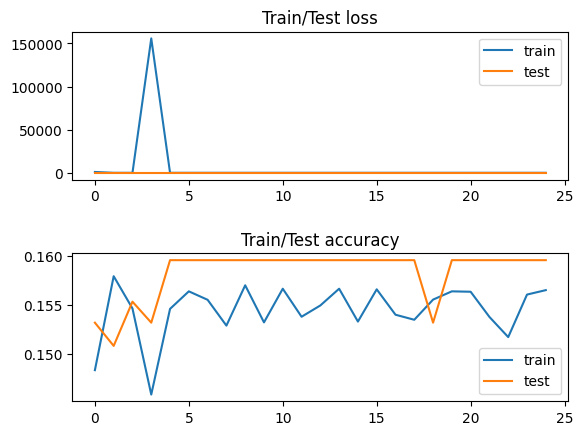

In [229]:
fig, axs = plt.subplots(2)
plt.subplots_adjust(hspace=0.5)
axs[0].plot(np.arange(epochs), [x.detach().cpu() for x in train_loss_lst], label = 'train')
axs[0].plot(np.arange(epochs), [x.detach().cpu() for x in test_loss_lst], label = 'test')
axs[0].set_title('Train/Test loss')
axs[0].legend()
axs[1].plot(np.arange(epochs), train_acc_lst, label = 'train')
axs[1].plot(np.arange(epochs), test_acc_lst, label = 'test')
axs[1].set_title('Train/Test accuracy')
axs[1].legend()
plt.show()

os.makedirs('folder', exist_ok=True)

In [230]:
dasalvare=[train_loss_lst,train_acc_lst,test_loss_lst,test_acc_lst]
with open("folder/prova6/dati6.txt", 'a') as file:
     file.write(f"{dasalvare}\n")

FileNotFoundError: [Errno 2] No such file or directory: 'folder/prova6/dati6.txt'

In [ ]:
best_model.eval()
test_loader = DataLoader(data, batch_size=10, shuffle=False)
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_model(inputs) 
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()